In [31]:
import os
import numpy as np
import pandas as pd
import umap
import time
from Bio import SeqIO
from embeddings_config import avail_models
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Patch
import mpl_stylesheet
mpl_stylesheet.banskt_presentation(fontfamily = 'mono', fontsize = 20, colors = 'banskt', dpi = 300)

target_uniprots = ["P37840", "P04637", "P02686", "P07305", "O00488", "Q9NYB9", "P06401", "Q16186", "S6B291", "P23441"]

# P37840: alpha synyclein 100%
# P04637: p53 37%
# P02686: myelin 56%
# P07305: histone h1 57%
# O00488: zing finger 55%
# Q9NYB9: abl interactor 2 69%
# P06401: progesterone receptor 63%
# Q16186: Proteasomal ubiquitin receptor ADRM1
# S6B291: IgG H chain
# P23441: Homeobox protein nkx

In [32]:
def get_kmers(seq, K=30):
    start = 0
    end   = len(seq)
    kmers = list()
    ranges= list()
    for i in range(start, end):
        if i > len(seq)-K or ((i+K)>len(seq)):
            break
        else:
            kmers.append(seq[i:i+K])
            ranges.append(f"{i}_{i+K}")
    return kmers, ranges

def get_embedding_kmers(emb, K=30):
    start = 0
    aa_len= emb.shape[0]
    end   = aa_len ## aa length
    kmers = list()
    ranges= list()
    for i in range(start, end):
        if i > aa_len-K or ((i+K)>aa_len):
            break
        else:
            kmers.append(emb[i:i+K,:])
            # ranges.append(f"{i}_{i+K}")
    return kmers

def get_sequences(fastadir=None, fastafile=None):
    sequences = []
    if fastadir is None and fastafile is None:
        print("No fasta dir or file")
        raise
    if fastadir is not None and fastafile is not None:
        print("Choose one, fasta dir or multi fasta filr")
        raise
    # check for a directory with individual fasta files
    # or a multi fasta file
    if fastadir is not None:
        fastafiles = os.listdir(fastadir)
        for f in fastafiles:
            counter = 0
            for record in SeqIO.parse(os.path.join(fastadir, f), "fasta"):
                sequences.append(record)
                counter += 1
                if counter > 1:
                    print("More than one fasta record?", f)
                    raise
    elif fastafile is not None:
        for record in SeqIO.parse(fastafile, "fasta"):
            sequences.append(record)
    return sequences

In [33]:
import shutil
# Load disprot embedding and annot data


# Disprot
embeddir="/data/franco/disorder_flavours/testset/" #"/data/franco/datasets/prot_embedding_weights/disprot/halft5/"
fasta_dir = "/data/franco/disorder_flavours/testset/" #"/data/franco/datasets/disprot/fasta/"
fasta_files = [f"{u}.fasta" for u in target_uniprots]
counter = 0

# find annotation for each sequence
annotfile = "/data/franco/disorder_flavours/testset/DisProt_release_2022_06_reformat_annot.fasta" #/data/franco/datasets/disprot/
annotdir  = None
annots    = get_sequences(fastadir=annotdir, fastafile=annotfile)

annot_dict = dict()
for record in annots:
    if "|" in record.name:
        name = record.name.split("|")[1].strip()
    else:
        name = record.name.split()[0].strip()
        if name == "":
            print("Name is empty",record.name)
    annot_dict[name] = str(record.seq)

sequences  = list()
embeddings = list()
uniprots   = list()
disprot_annotations = list()
for ff in fasta_files:
    uniprot_id = ff.rstrip().split(".")[0]
    if uniprot_id in target_uniprots:
        embedfile = os.path.join(embeddir, f"{uniprot_id}.gz")
        fastafile = os.path.join(fasta_dir, ff)
        if os.path.exists(fastafile):
            rcounter = 0
            for record in SeqIO.parse(fastafile, "fasta"):
                sequences.append(record)
                rcounter += 1
                if rcounter > 1:
                    print("More than one fasta record?", f)
                    raise
            aa_sequence = str(record.seq).upper()
            if os.path.exists(embedfile):
                emb = np.loadtxt(embedfile)
                if emb.shape[0] == len(annot_dict[uniprot_id]) and len(aa_sequence) == len(annot_dict[uniprot_id]):
                    embeddings.append(emb)
                    uniprots.append(uniprot_id)
                    disprot_annotations.append(annot_dict[uniprot_id])
                    counter += 1
                else:
                    print("Embedding length and annot do not match")
                    print(emb.shape, len(annot_dict[uniprot_id]), uniprot_id, len(aa_sequence))
print(f"Loaded {counter} protein embeddings")

Loaded 10 protein embeddings


In [34]:
#### FAST KMER EMBEDDINGS #####
# obtain kmer embeddings from original whole protein embedding, and apply mean function
K = 30
disprot_fastkmer_mean_embeddings = list()
length_list = list()
for single_emb in embeddings:
    emb_kmer  = get_embedding_kmers(single_emb, K=K)
    length_list.append(len(emb_kmer))
    emb_kmers = [np.mean(x, axis=0) for x in emb_kmer] # make a list of mean embedding kmers
    disprot_fastkmer_mean_embeddings = disprot_fastkmer_mean_embeddings + emb_kmers
print(len(disprot_fastkmer_mean_embeddings))

3566


In [35]:
#### TRUE KMER EMBEDDINGS #####
sel_embedding = 'halft5'

true_kmerdict = dict()
ksequences = []
kannotations = []
kembeddings = []
kmers_per_prot = []
for i, uniprot_id in enumerate(uniprots):
    kmers_file = f"testset/{uniprot_id}_kmers{K}.fasta"
    if os.path.exists(kmers_file):
        records = get_sequences(fastadir=None, fastafile=kmers_file)
        this_sequences = []
        this_embeddings = []
        for r in records:
            kmer_id = r.id
            embedfile = f"testset/{kmer_id}.gz"
            if os.path.exists(embedfile):
                this_sequences.append(str(r.seq))
                this_embeddings.append(np.loadtxt(embedfile))
            else:
                print(f"File does not exist:{embedfile}")
        annotmers, ranges = get_kmers(disprot_annotations[i], K=K)
        if len(annotmers) == len(this_embeddings) and len(annotmers) == len(this_sequences):
            kannotations = kannotations + annotmers
            ksequences = ksequences + this_sequences
            kembeddings = kembeddings + this_embeddings
            kmers_per_prot = kmers_per_prot + [len(this_sequences)]
        else:
            print(f"Some length does not match: {uniprot_id},{i}")
            print(len(annotmers), len(this_embeddings), len(this_sequences))
            raise
true_kmerdict['seqs']   = ksequences
true_kmerdict['annot']  = kannotations
true_kmerdict['embded'] = kembeddings
true_kmerdict['n_kmers']= kmers_per_prot


In [36]:
true_kmer_whole_embeddings = []
for e in true_kmerdict['embded']:
    true_kmer_whole_embeddings.append(np.mean(e, axis=0))

In [37]:
# obtain kmer annotations
disprot_kmer_annotations = list()
length_list_annots = list()
for dannot in disprot_annotations:
    annot_kmers, annot_ranges = get_kmers(dannot, K=K)
    length_list_annots.append(len(annot_kmers))
    for kmer in annot_kmers:
        disprot_kmer_annotations.append(kmer)

In [38]:
print(kembeddings[0].shape)
print(len(disprot_kmer_annotations))
print(np.array(disprot_fastkmer_mean_embeddings).shape)  # fast kmer embeddings
print(np.array(true_kmer_whole_embeddings).shape)        # true kmer embeddings



(30, 1024)
3566
(3566, 1024)
(3566, 1024)


In [39]:
print(np.sum(kmers_per_prot))
print(kmers_per_prot)

3566
[111, 364, 275, 165, 105, 484, 904, 378, 437, 343]


In [40]:
def get_contents(annotations):
    disorder_contents = list()
    for da in annotations:
        contents = [ x != "-" for x in da]
        DC = np.sum(contents) / len(contents)
        disorder_contents.append(DC)
    return disorder_contents

disprot_kmer_disorder_contents = get_contents(disprot_kmer_annotations)
print(len(disprot_kmer_disorder_contents))

3566


In [41]:
print(f"DIFF={len(disprot_kmer_disorder_contents) - np.array(disprot_fastkmer_mean_embeddings).shape[0]}")

DIFF=0


In [42]:
import umap
print("Calculating 1st UMAP")
my_fast_umap = umap.UMAP(n_neighbors=200, min_dist=.25)
umap_fast_embedding = my_fast_umap.fit_transform(np.array(disprot_fastkmer_mean_embeddings))

print("Calculating 2nd UMAP")
my_true_umap = umap.UMAP(n_neighbors=200, min_dist=.25)
umap_true_embedding = my_true_umap.fit_transform(np.array(true_kmer_whole_embeddings))


Calculating 1st UMAP
Calculating 2nd UMAP


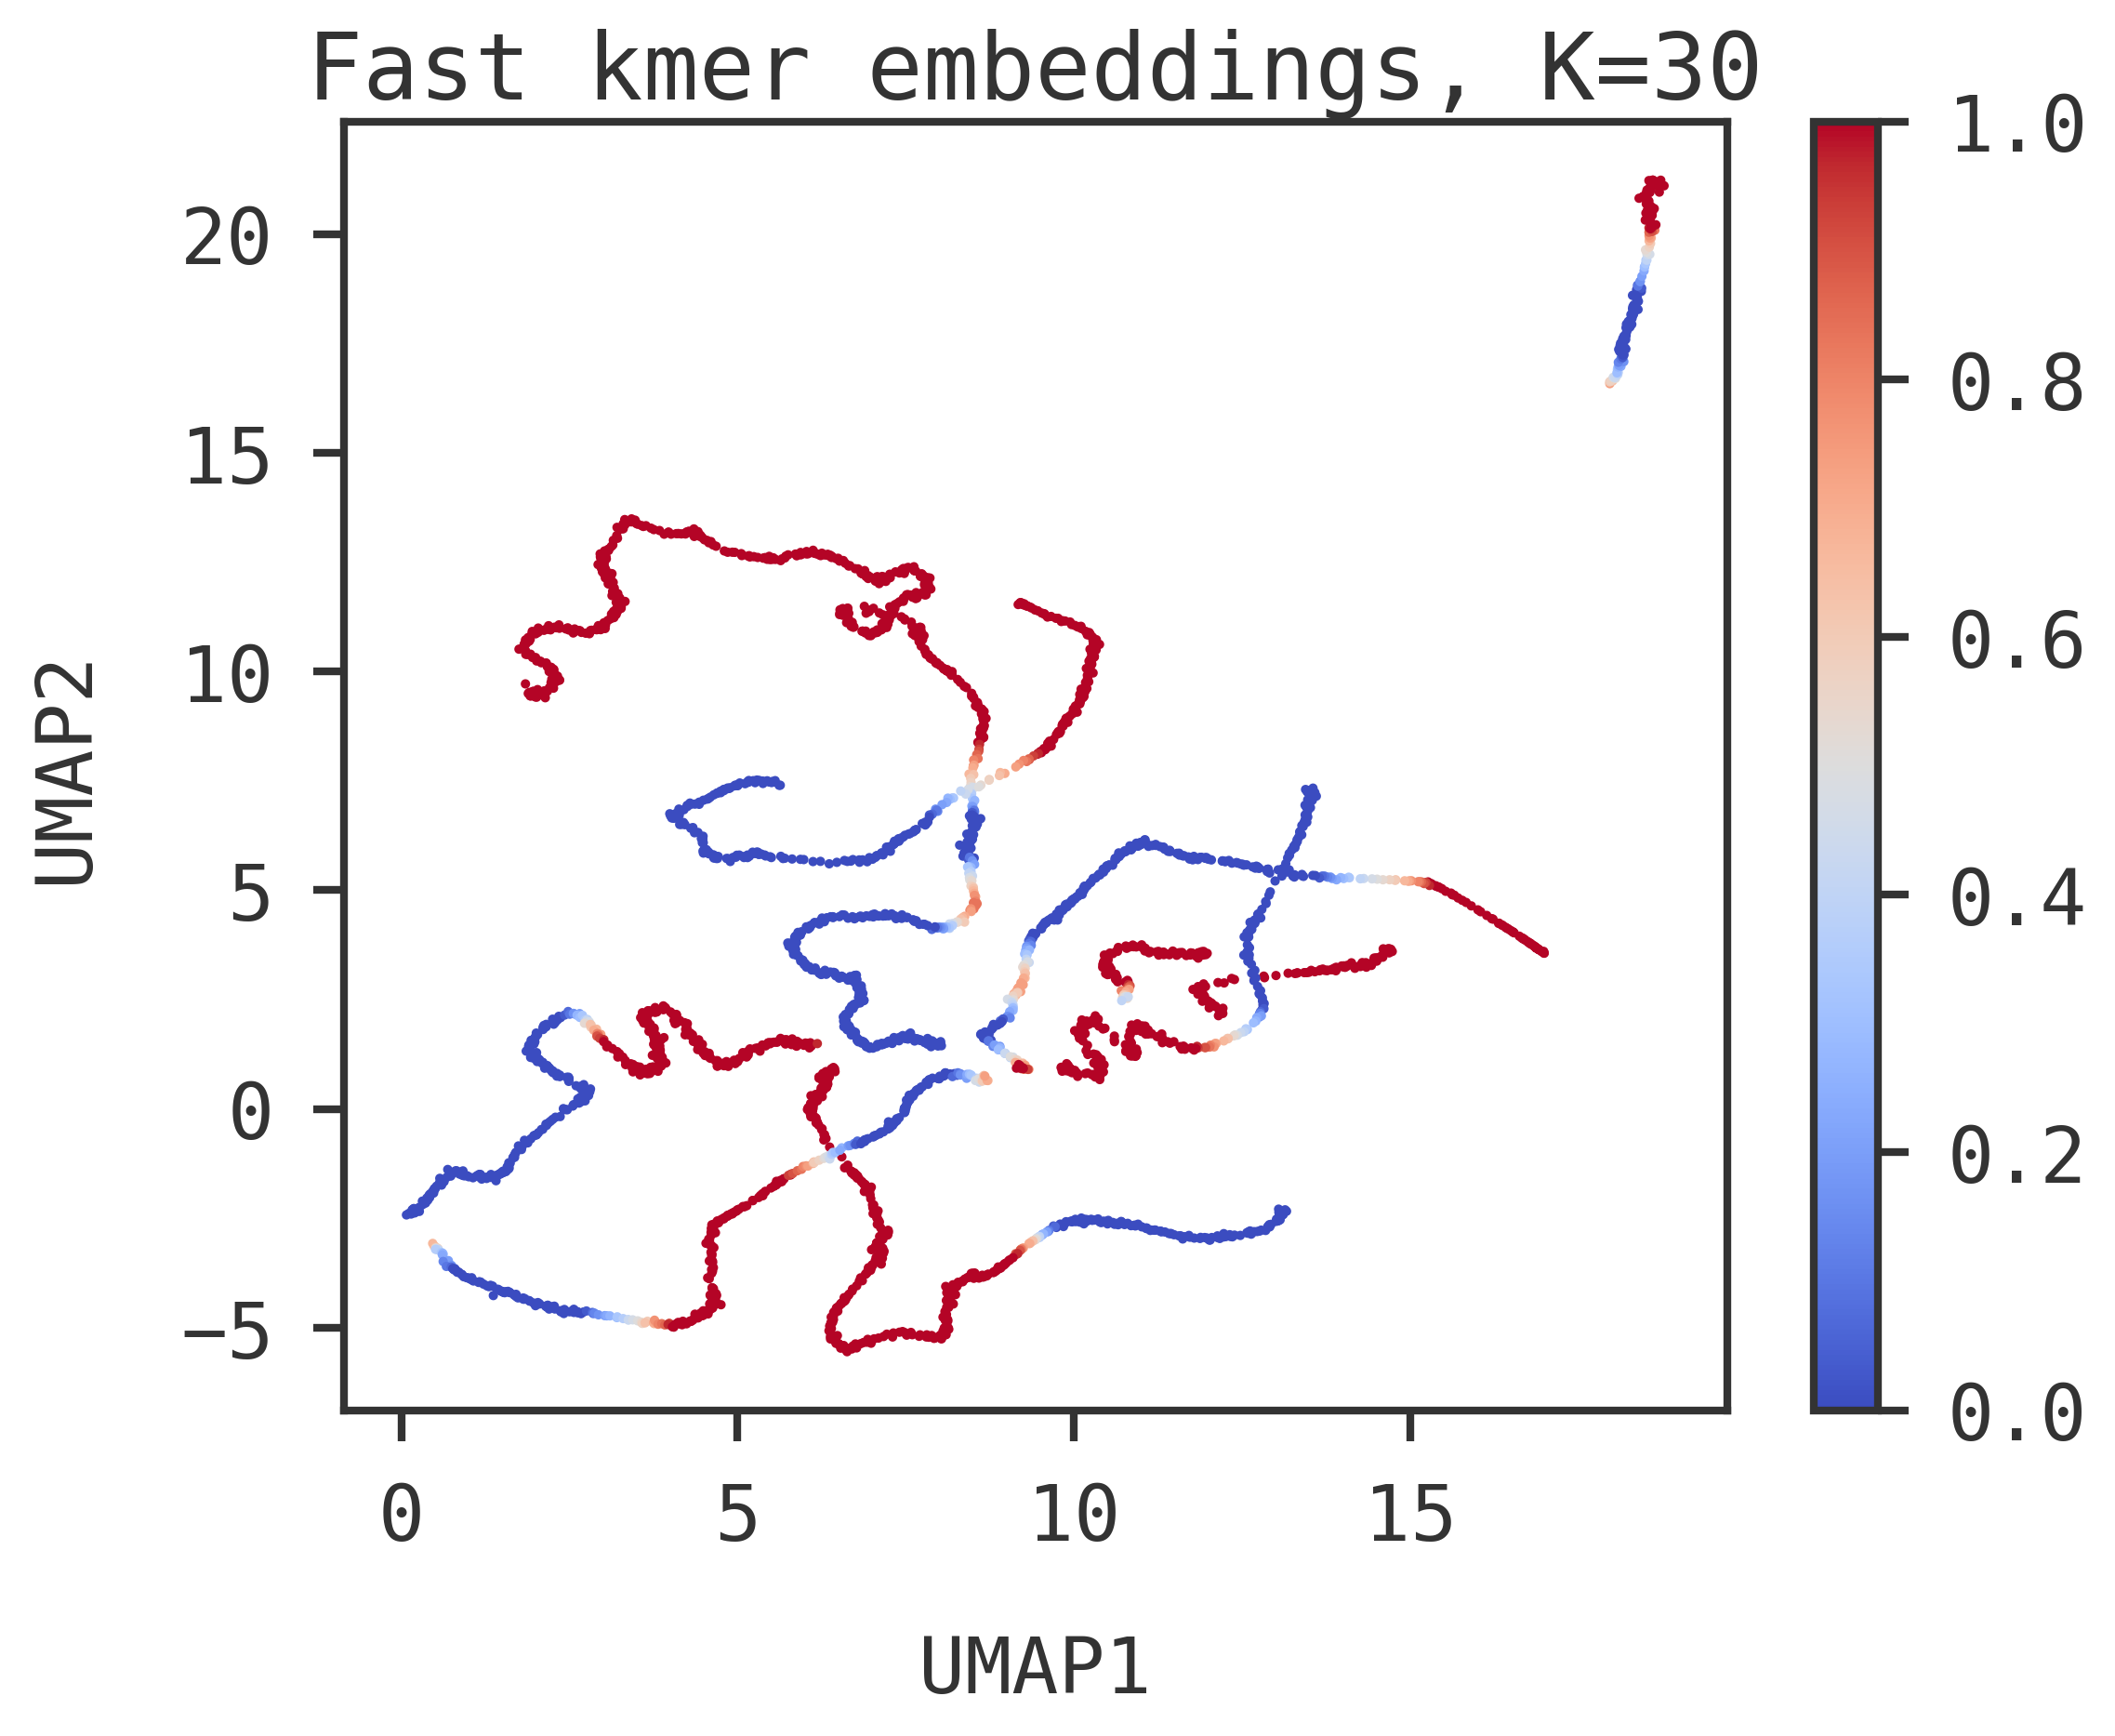

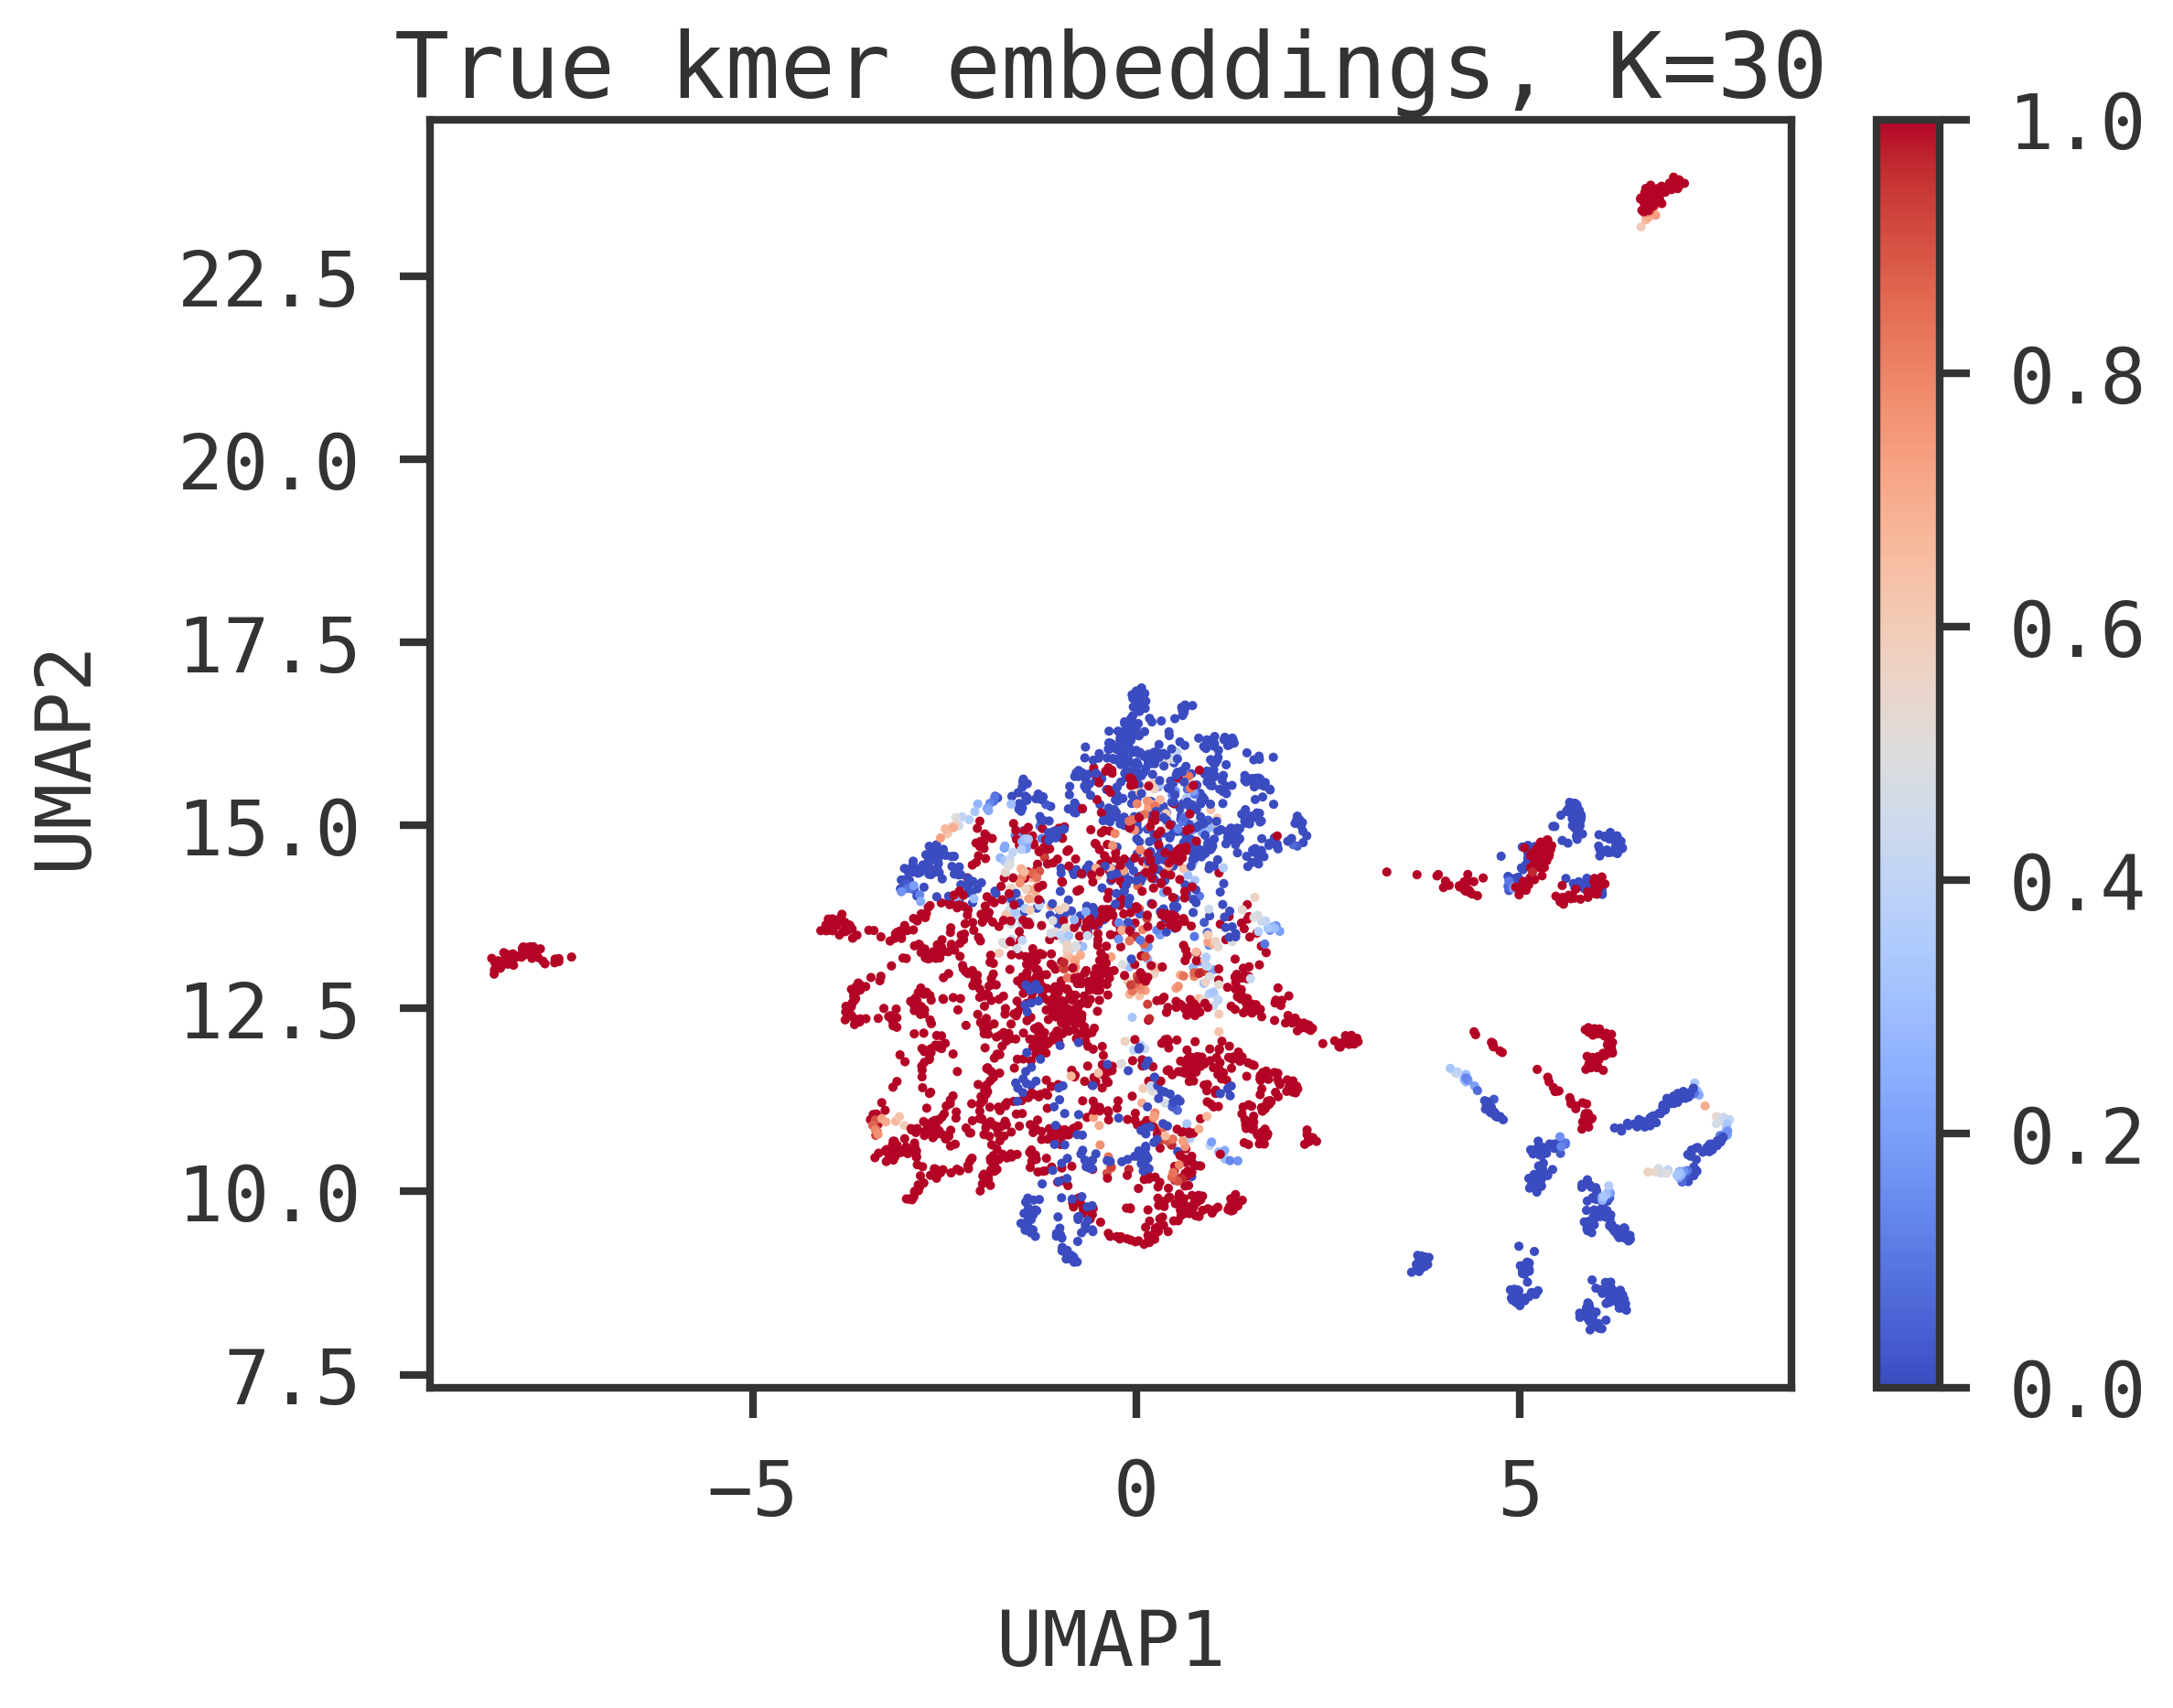

In [43]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import mpl_stylesheet
mpl_stylesheet.banskt_presentation(fontfamily = 'mono', fontsize = 20, colors = 'banskt', dpi = 300)


fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)

cmap = plt.get_cmap("coolwarm")
sc = ax1.scatter(umap_fast_embedding[:,0], umap_fast_embedding[:,1], c=disprot_kmer_disorder_contents, s=2, cmap=cmap)
ax1.set_xlabel("UMAP1")
ax1.set_ylabel("UMAP2")
ax1.set_title(f"Fast kmer embeddings, K={K}")
plt.colorbar(sc, ax=ax1)
# plt.savefig(f"plots/kmers_embeddings_k{K}.png", bbox_inches='tight')
plt.show()


fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)

cmap = plt.get_cmap("coolwarm")
sc = ax1.scatter(umap_true_embedding[:,0], umap_true_embedding[:,1], c=disprot_kmer_disorder_contents, s=2, cmap=cmap)
ax1.set_xlabel("UMAP1")
ax1.set_ylabel("UMAP2")
ax1.set_title(f"True kmer embeddings, K={K}")
plt.colorbar(sc, ax=ax1)
# plt.savefig(f"plots/kmers_embeddings_k{K}.png", bbox_inches='tight')
plt.show()

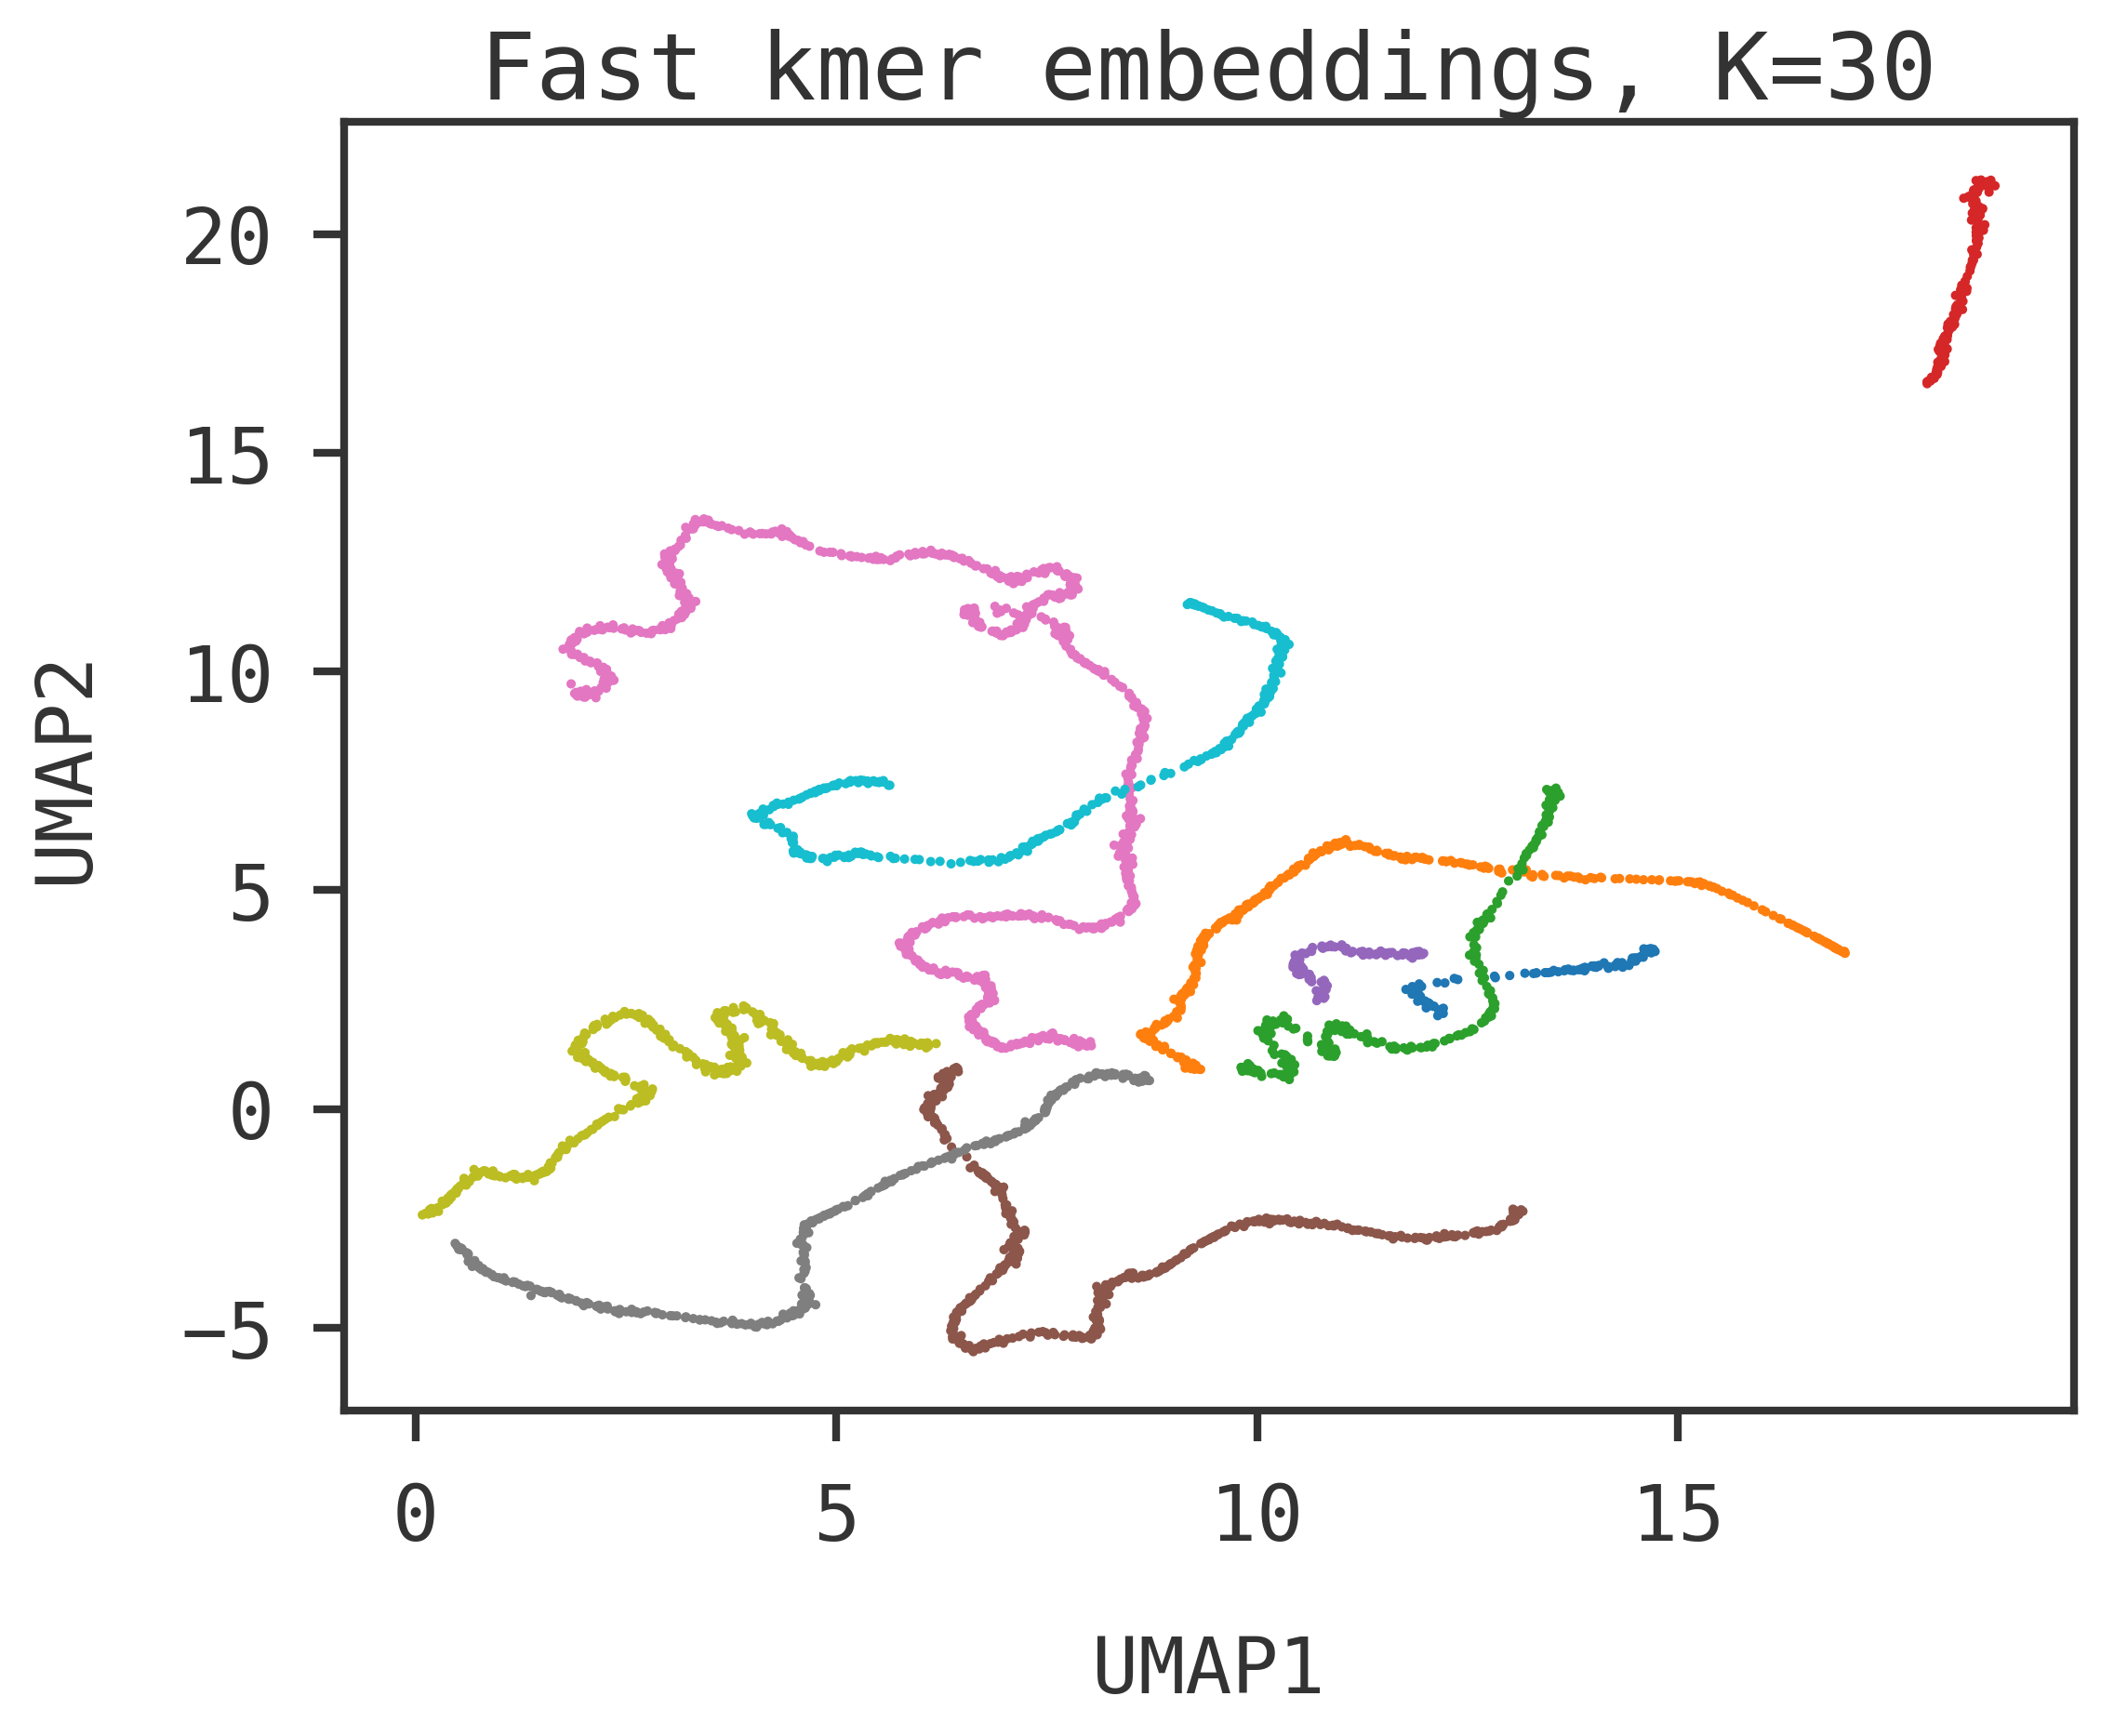

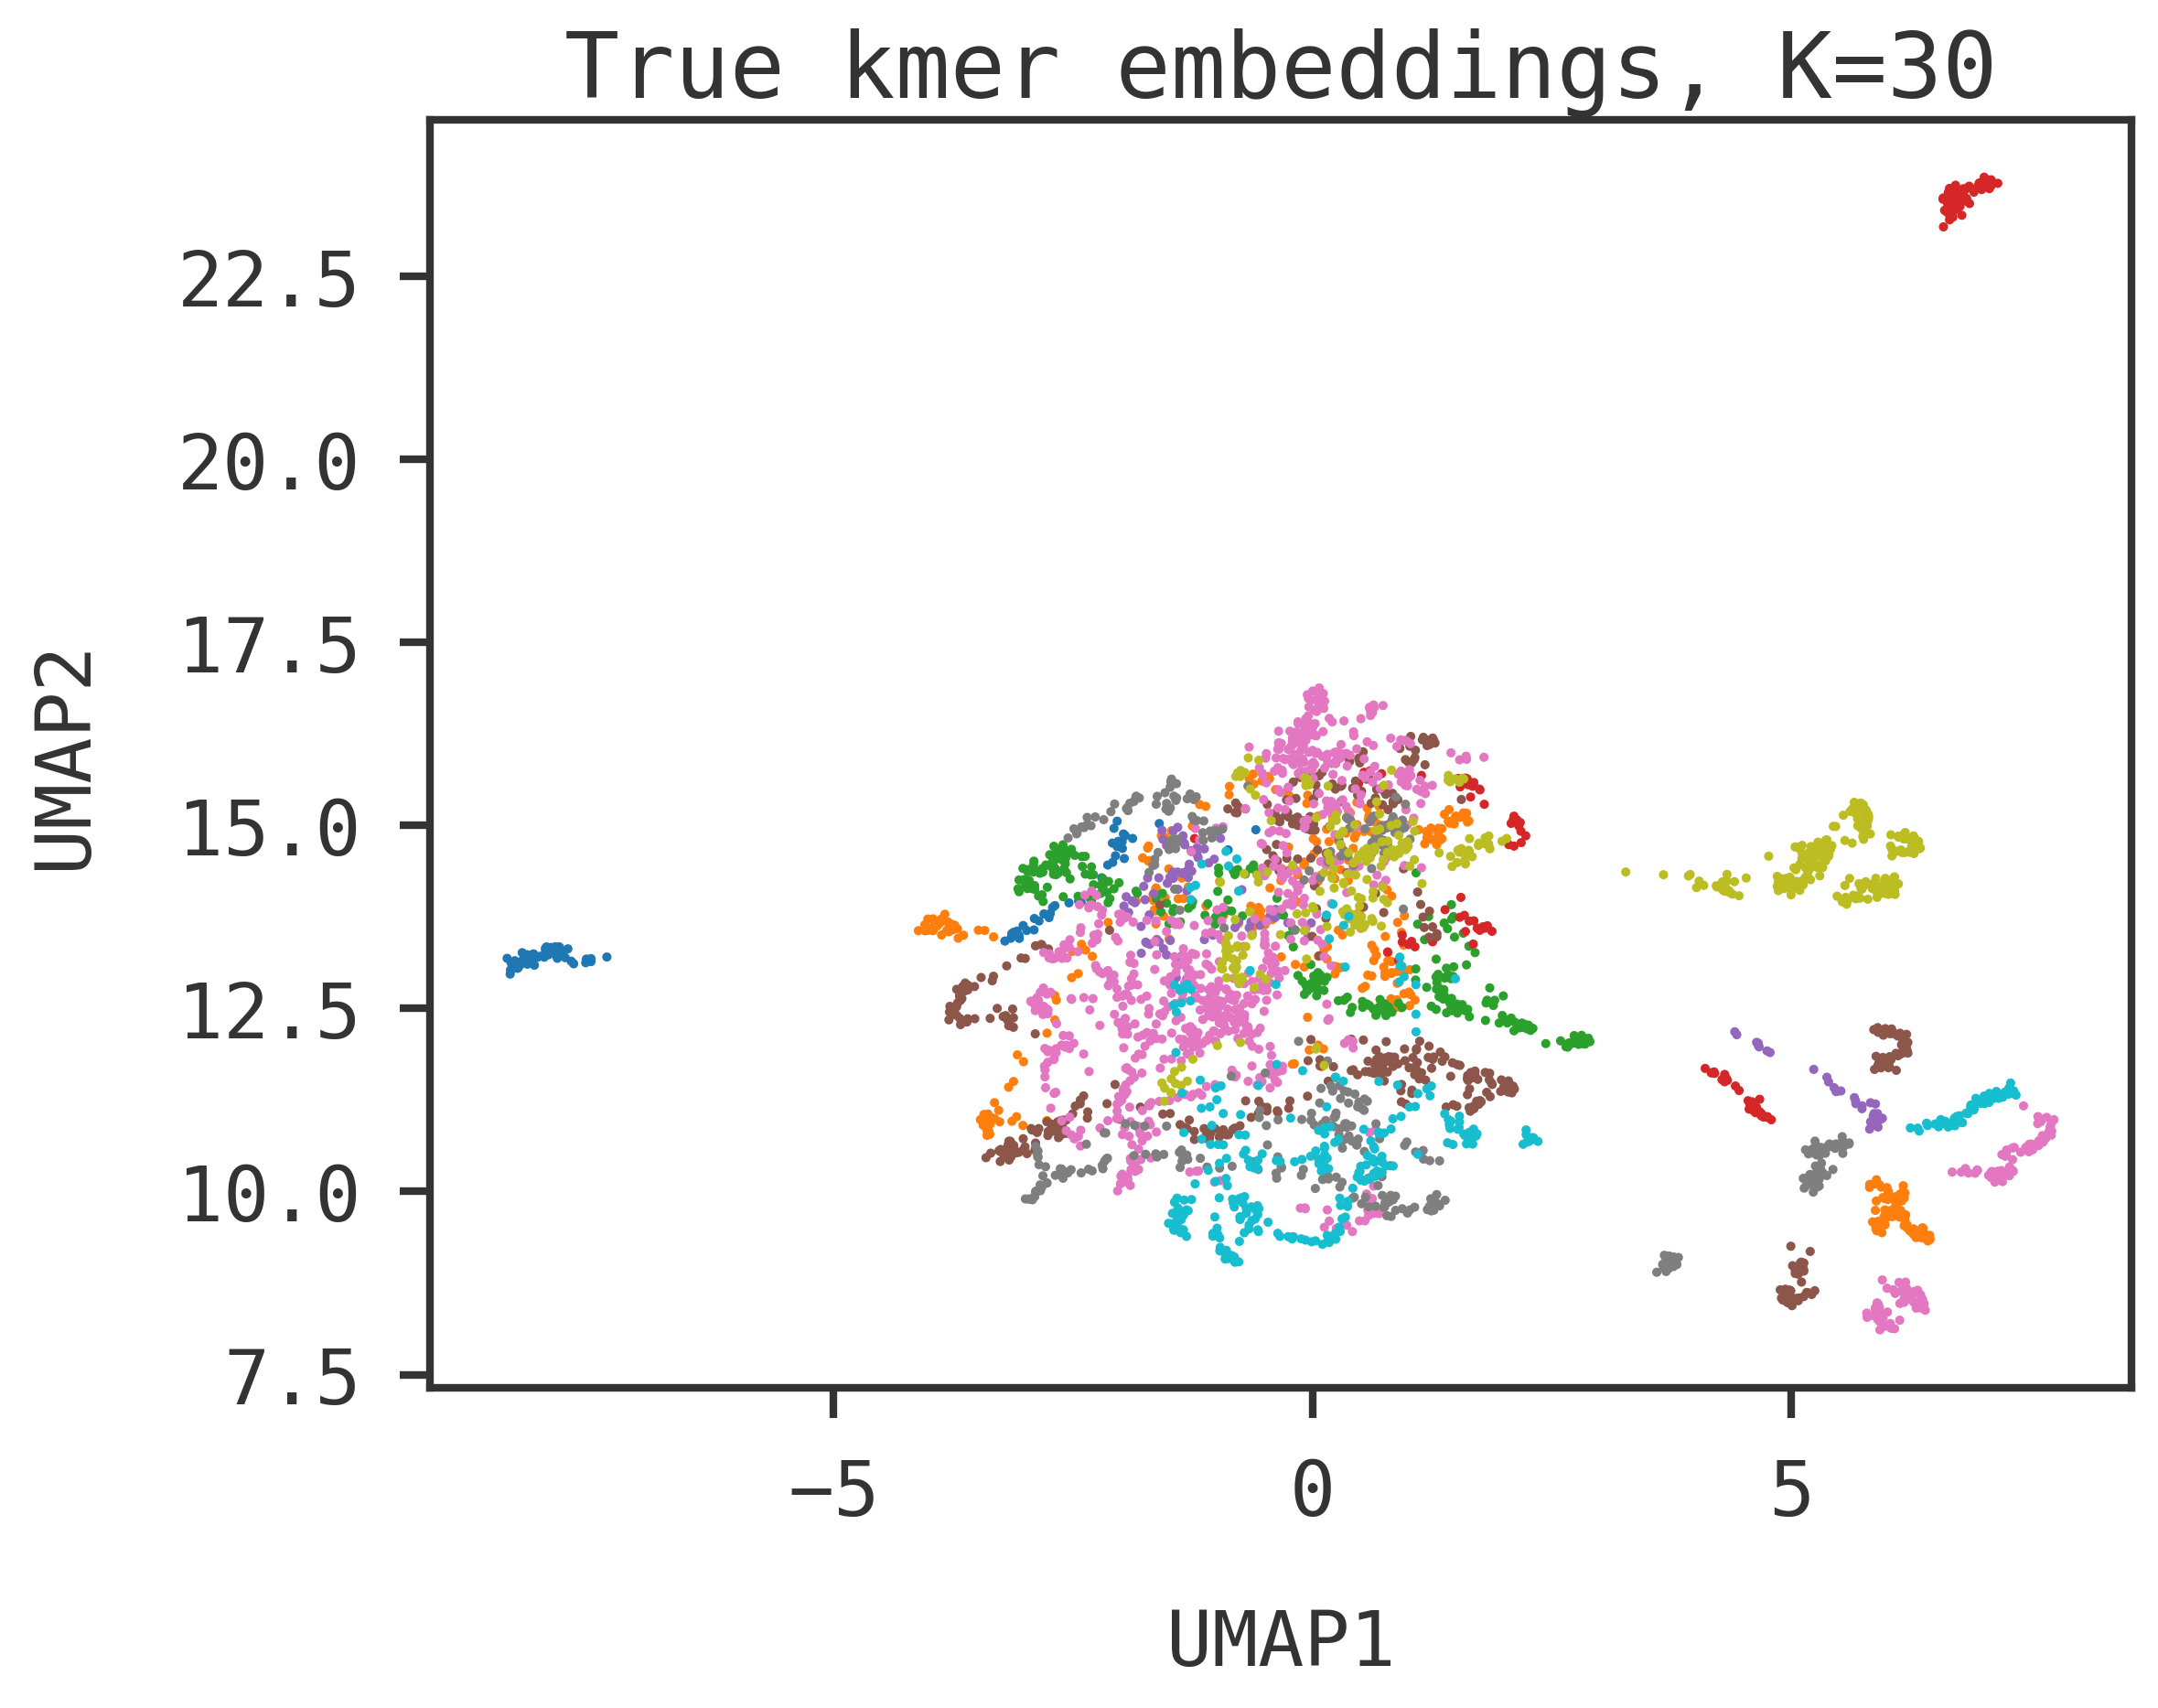

In [44]:
prot_colors = list()
for i,l in enumerate(length_list):
    prot_colors = prot_colors + list(np.repeat(i/len(length_list), l))

fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)

cmap = plt.get_cmap("tab10")
sc = ax1.scatter(umap_fast_embedding[:,0], umap_fast_embedding[:,1], c=prot_colors, s=2, cmap=cmap)
ax1.set_xlabel("UMAP1")
ax1.set_ylabel("UMAP2")
ax1.set_title(f"Fast kmer embeddings, K={K}")
# plt.colorbar(sc, ax=ax1)
plt.savefig(f"plots/fast_kmers_embeddings_k{K}_byprot.png", bbox_inches='tight')
plt.show()

fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)

cmap = plt.get_cmap("tab10")
sc = ax1.scatter(umap_true_embedding[:,0], umap_true_embedding[:,1], c=prot_colors, s=2, cmap=cmap)
ax1.set_xlabel("UMAP1")
ax1.set_ylabel("UMAP2")
ax1.set_title(f"True kmer embeddings, K={K}")
# plt.colorbar(sc, ax=ax1)
plt.savefig(f"plots/true_kmers_embeddings_k{K}_byprot.png", bbox_inches='tight')
plt.show()

In [ ]:
## single protein plot
protnum = 1
print(kmers_per_prot)
uniprot = uniprots[protnum]
if protnum == 0:
    start = 0
else:
    start = np.sum(kmers_per_prot[0:protnum])
end = np.sum(kmers_per_prot[0:protnum+1])
                
print(start, end)

target_prot_ix = np.arange(start, end)

fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

cmap = plt.get_cmap("coolwarm")
sc = ax1.scatter(umap_fast_embedding[target_prot_ix,0], umap_fast_embedding[target_prot_ix,1], c=np.array(disprot_kmer_disorder_contents)[target_prot_ix], s=1, cmap=cmap)
ax1.set_xlabel("UMAP 1")
ax1.set_ylabel("UMAP 2")
ax1.set_title(f"{uniprot}")

sc2 = ax2.scatter(umap_true_embedding[target_prot_ix,0], umap_true_embedding[target_prot_ix,1], c=np.array(disprot_kmer_disorder_contents)[target_prot_ix], s=1, cmap=cmap)
ax2.set_xlabel("UMAP 1")
ax2.set_ylabel("UMAP 2")
ax2.set_title(f"{uniprot}")

plt.colorbar(sc, ax=ax1)
plt.show()

In [45]:
target_prot_fastkmer_embeds = np.array(disprot_fastkmer_mean_embeddings)[target_prot_ix,:]
target_prot_truekmer_embeds = np.array(true_kmer_whole_embeddings)[target_prot_ix,:]

target_combined_embeds = np.vstack([target_prot_fastkmer_embeds, target_prot_truekmer_embeds])

In [46]:
my_comb_umap = umap.UMAP(n_neighbors=200, min_dist=.7)
umap_comb_embedding = my_comb_umap.fit_transform(target_combined_embeds)


In [ ]:

this_colors = np.concatenate((np.array(disprot_kmer_disorder_contents)[target_prot_ix], np.array(disprot_kmer_disorder_contents)[target_prot_ix]))

for N in [25,50,100,200]:
    for M in [0.05, 0.2, 0.5, 0.7]:

        my_comb_umap = umap.UMAP(n_neighbors=N, min_dist=M)
        umap_comb_embedding = my_comb_umap.fit_transform(target_combined_embeds)


        fig = plt.figure(figsize=(16,6))
        ax1 = fig.add_subplot(111)

        cmap = plt.get_cmap("coolwarm")
        sc = ax1.scatter(umap_comb_embedding[:,0], umap_comb_embedding[:,1], c=this_colors, s=1, cmap=cmap)
        ax1.set_xlabel("UMAP 1")
        ax1.set_ylabel("UMAP 2")
        ax1.set_title(f"{uniprot} n_neig={N}, dist={M}")

        plt.colorbar(sc, ax=ax1)
        plt.show()